# Polynomial Order/Window length tunning

In [1]:
import numpy as np
import pandas as pd
import time

from scipy.signal import savgol_filter,butter, lfilter,filtfilt, bessel
from scipy.stats import iqr
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.fft import fft,fftfreq

from bokeh.io import output_file, show
from bokeh.layouts import column
from bokeh.plotting import figure, show,output_file
from bokeh.palettes import Dark2_5 as palette
from bokeh.models import HoverTool,tools,BasicTickFormatter,Range1d,Span
import itertools

import matplotlib.pyplot as plt

from PreparingMethod import TP_detect,baseline_als

In [2]:
file_list = ["./RawData_Baby_Sensorpatch2/2021-09-08_15-21-54_2021-09-08_15-24-06_sensor_input_5000_1631107314600325.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-21-54_2021-09-08_15-26-17_sensor_input_5000_1631107314600325.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-21-54_2021-09-08_15-28-29_sensor_input_5000_1631107314600325.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-21-54_2021-09-08_15-30-40_sensor_input_5000_1631107314600325.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-21-54_2021-09-08_15-32-12_sensor_input_3516_1631107314600325.csv",
         
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-32-19_2021-09-08_15-34-31_sensor_input_5000_1631107939624088.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-32-19_2021-09-08_15-36-42_sensor_input_5000_1631107939624088.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-32-19_2021-09-08_15-38-54_sensor_input_5000_1631107939624088.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-32-19_2021-09-08_15-41-05_sensor_input_5000_1631107939624088.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-32-19_2021-09-08_15-42-23_sensor_input_2979_1631107939624088.csv",
         
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-42-30_2021-09-08_15-44-42_sensor_input_5000_1631108550428185.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-42-30_2021-09-08_15-46-53_sensor_input_5000_1631108550428185.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-42-30_2021-09-08_15-49-05_sensor_input_5000_1631108550428185.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-42-30_2021-09-08_15-51-16_sensor_input_5000_1631108550428185.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-42-30_2021-09-08_15-52-23_sensor_input_2560_1631108550428185.csv",
         
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-52-28_2021-09-08_15-54-40_sensor_input_5000_1631109148920218.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-52-28_2021-09-08_15-56-52_sensor_input_5000_1631109148920218.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-52-28_2021-09-08_15-59-03_sensor_input_5000_1631109148920218.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-52-28_2021-09-08_16-01-14_sensor_input_5000_1631109148920218.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_15-52-28_2021-09-08_16-02-05_sensor_input_1937_1631109148920218.csv",
         
             "./RawData_Baby_Sensorpatch2/2021-09-08_16-02-09_2021-09-08_16-04-21_sensor_input_5000_1631109729643834.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_16-02-09_2021-09-08_16-06-32_sensor_input_5000_1631109729643834.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_16-02-09_2021-09-08_16-08-44_sensor_input_5000_1631109729643834.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_16-02-09_2021-09-08_16-10-55_sensor_input_5000_1631109729643834.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_16-02-09_2021-09-08_16-13-07_sensor_input_5000_1631109729643834.csv",
             "./RawData_Baby_Sensorpatch2/2021-09-08_16-02-09_2021-09-08_16-14-15_sensor_input_2585_1631109729643834.csv"]

In [3]:
input_data = pd.read_csv(file_list[0]).to_numpy()

sensors_value = np.clip(input_data[:,1:],a_min = 0, a_max = 4095)    # 36sensors value
timelineinsec = input_data[:,0]/1000000                              # time in us -> time in second

num_messdata, num_sensors = sensors_value.shape

time_diff = np.diff(timelineinsec).mean()   # get the mean value of the deita time(in two sensor signal)
sample_rate = 1/time_diff                    # sample rate, ~38Hz

# for FFT
samp_space  = 1/sample_rate
x_f         = fftfreq(num_messdata,samp_space)[:num_messdata//2]

In [4]:
# read the mean trigger points index from excel
df_trigger = pd.read_excel(r'.\LabelingDataSet\15-24-06_MeanData.xlsx').to_numpy(dtype = int)
Mean_trigger = df_trigger[:,0].reshape(-1)
Sensor8_trigger = df_trigger[:,1].reshape(-1)
#Mean_trigger = df_trigger..reshape(-1)   # index in columns
len(Mean_trigger)

305

In [5]:
lam = 10e3
p = 0.5

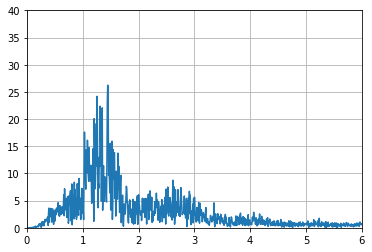

---window length: 9---
number of FC when peak points: 158
number of FC when tough points: 165
number of CC points: 868
-WRT Sensor8 TR-
Absoulte Error Mean: 0.6426229508196721
Error Mean: -0.3016393442622951
-WRT Mean TR-
Absoulte Error Mean: 0.9344262295081968
Error Mean: 0.28524590163934427


In [6]:
sensor_8 = sensors_value[:,7]

# window_length
#win_len = np.array([7,9,11,13,15,17,19])
#win_len = np.array([19])
win_len = np.array([9])  # 11,13
polyorder = 5

# check if there are some unsupposed trigger points

output_file('Sensor 8 baseline+Savfilter.html')
tooltips = [("index", "$index"),
            ("time", "$x"),
            ("value", "$y")]  
f = figure(width=1500, height=700, 
            title= 'Sensor Nr.8 Baseline + SaviskyFilter PolyOrder',
            x_axis_label='Time [s]', y_axis_label='Sensor Value')
f.title.text_font_size = '20pt'
f.axis.major_label_text_font_size="16pt"
f.axis.axis_label_text_font_size = "20pt"

f.add_tools(HoverTool(tooltips = tooltips, mode = 'mouse'))
colors = itertools.cycle(palette)

f.line(timelineinsec[3800:], sensor_8[3800:], legend_label="Original", line_width= 5, line_color='black')

for i_len,color in zip(win_len,colors):
    
    Sav_filter_win =savgol_filter(sensor_8,i_len,polyorder,mode='nearest')

    # baseline of sensor 8
    baseline_sensor8 = baseline_als(Sav_filter_win,lam,p)
    
    # plot baseline in Bokeh
    f.line(timelineinsec[3800:],baseline_sensor8[3800:],legend_label = 'Baseline', line_width = 1, line_color = 'blue')
    
    # norm_sensor 8 
    norm_sensor8 = Sav_filter_win - baseline_sensor8
    FC_peak_index,FC_tough_index,FC_peak,FC_tough,CC = TP_detect(norm_sensor8)
    
    fft_norm = fft(norm_sensor8)
    
    plt.plot(x_f, 2.0/num_messdata*np.abs(fft_norm[0:num_messdata//2]))
    plt.grid()
    plt.xlim((0,6))
    plt.ylim((0,40))
    plt.show()
    plt.close()
    
    print('---window length: '+str(i_len)+'---')
    print('number of FC when peak points: '+str(FC_peak))
    print('number of FC when tough points: '+str(FC_tough))
    print('number of CC points: '+str(CC))
        
    f.line(timelineinsec[3800:], Sav_filter_win[3800:], legend_label="SavFilter"+str(i_len), line_width= 2, line_color=color)
    f.line(timelineinsec[3800:], norm_sensor8[3800:], legend_label='Norm_winlen'+str(i_len), line_width= 5, line_color=color)

    #f.circle(timelineinsec[FC_peak_index],norm_sensor8[FC_peak_index],color = '#B83B5E')
    #f.circle(timelineinsec[FC_tough_index],norm_sensor8[FC_tough_index],color = '#6A2C70')
    
    if i_len == 7:
        remove_tough = [31,35,37,40,67,87,88,124,125,131,147]
        remove_peak = [0,118, 119]  
    if i_len == 9:
        remove_tough = [16, 32, 36,39, 41,68,78,89,90,105,127,128,134,150]
        remove_peak = [0, 118, 119,142]
    if i_len == 11:
        remove_tough = [0, 17, 36,39,41,48,78,89,90,91, 127,128,134,150]
        remove_peak = [0,118, 119, 142]
    if i_len == 13:
        remove_tough = [0, 3, 18, 34, 38,42, 60, 67,70,72,87,93,94,95,110,132,133,134,140,156]
        remove_peak = [0, 118, 119,142]
    if i_len == 15:
        remove_tough = [0, 3,18,40,64,67,78,84,90,91,106,128,129,130,136,152]
        remove_peak = [0, 118, 119,142]
    if i_len == 17:
        remove_tough = [0, 30,39,65,67,87,88,103,125,126,127,133,149 ]
        remove_peak = [0, 118, 119,142]
    if i_len == 19:
        remove_tough = [0, 17,31,64,66,68,78,89,90,105,127,128,129,135,151]
        remove_peak = [0, 118, 119,142]
        
    FC_tough_index_re = np.delete(np.array(FC_tough_index),remove_tough)
    FC_peak_index_re = np.delete(np.array(FC_peak_index),remove_peak)
    FC_tr = np.sort(np.hstack((FC_tough_index_re,FC_peak_index_re)))
    
    # evaluate
    # WRT Sensor8 TR
    S8_error_mean_abs = np.mean(abs(Sensor8_trigger -  FC_tr))
    S8_error_mean     = np.mean(FC_tr - Sensor8_trigger)
    print('-WRT Sensor8 TR-')
    print('Absoulte Error Mean: '+ str(S8_error_mean_abs))
    print('Error Mean: '+ str(S8_error_mean))
    
    # WRT Mean TR
    error_mean_abs = np.mean(abs(Mean_trigger -  FC_tr))
    error_mean     = np.mean(FC_tr - Mean_trigger)
    print('-WRT Mean TR-')
    print('Absoulte Error Mean: '+ str(error_mean_abs))
    print('Error Mean: '+ str(error_mean))
#f.circle(timelineinsec[Mean_trigger],norm_sensor8[Mean_trigger],color = 'red')

show(f)

## Evaluate

In [7]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog = False)
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    # y = lfilter(b, a, data)
    y = filtfilt(b, a, data,axis = 0)
    return y

In [8]:
def bessel_bandpass_filter(sig, lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    # bessel() and lfilter() are from scipy.signal

    b, a = bessel(order, [low, high], btype='band')
    # y = lfilter(b, a, sig)
    y = filtfilt(b, a, sig)
    return y

lowcut = 0.5
highcut = 2

In [9]:
output_file('Compare all filter.html')
s1 = figure(width=1500, height=400, 
            title= 'Compare of Savitzky, Butterworth and Bessel filter with order 5',
            x_axis_label='Time [s]', y_axis_label='Sensor Value')

s1.title.text_font_size = '25pt'
s1.axis.major_label_text_font_size="16pt"
s1.axis.axis_label_text_font_size = "20pt"

Sav_filter_win_ =savgol_filter(sensor_8,9,5,mode='nearest')
# baseline of sensor 8
baseline_sensor8_ = baseline_als(Sav_filter_win_,lam,p)
norm_sensor8_ = Sav_filter_win_ - baseline_sensor8_

# Butter filter
BP_sensor_8_o5 = butter_bandpass_filter(sensor_8,lowcut,highcut,sample_rate, order = 5)

# Bessel filter
Bessel_filter_5 = bessel_bandpass_filter(sensor_8,lowcut,highcut,sample_rate, order = 5)

s1.line(timelineinsec[500:600],sensor_8[500:600],legend_label = 'Orig', line_width = 2, line_color = 'black')

# plot Sav filter in Bokeh
s1.line(timelineinsec[500:600],norm_sensor8_[500:600],legend_label = 'Sav 5th', line_width = 2, line_color = 'blue')
    
# plot Butter filter in Bokeh
s1.line(timelineinsec[500:600], BP_sensor_8_o5[500:600], legend_label="Butter 5th", line_width= 1, line_color = '#BD4291')

# plot Bessel filter in Bokeh
s1.line(timelineinsec[500:600], Bessel_filter_5[500:600], legend_label="Bessel 5th", line_width= 1, line_color = '#0078AA')

s1.legend.label_text_font_size = '30pt'
show(s1)

In [10]:

output_file('Normalization.html')
s2 = figure(width=1500, height=400, 
            title= 'Normalisation of sensor 8',
            x_axis_label='Time [s]', y_axis_label='Sensor Value')

s2.title.text_font_size = '25pt'
s2.axis.major_label_text_font_size="16pt"
s2.axis.axis_label_text_font_size = "20pt"

# do the IQR to remove the outlier and get the up and lower envelop
low_sm_demo = np.quantile(norm_sensor8_,0.25)
up_sm_demo = np.quantile(norm_sensor8_,0.75)
IQR = up_sm_demo - low_sm_demo

# get the normalization pattern
norm_demo_zw = (norm_sensor8_ + 2*IQR )/4/IQR
norm_low_sm_ = (low_sm_demo + 2 * IQR)/4/IQR
norm_up_sm_ = (up_sm_demo + 2 * IQR)/4/IQR

norm_demo = np.clip(norm_demo_zw,0,1)

# plot original signal and Q1 & Q3
s2.line(timelineinsec[500:600], norm_sensor8_[500:600], legend_label="no offset", line_width= 2, line_color = 'black')

# Horizontal line
hline1 = Span(location=low_sm_demo, dimension='width', line_color='green', line_width=3)
hline2 = Span(location=up_sm_demo, dimension='width', line_color='blue', line_width=3)

s2.renderers.extend([hline1,hline2])


# plot Norm [0:1] in Bokeh
# s2.line(timelineinsec[500:600], norm_demo[500:600], legend_label="normalized", line_width= 2, line_color = 'black')
s2.legend.label_text_font_size = '30pt'
show(s2)